Found 42559 files belonging to 65 classes.
Using 34048 files for training.
Found 42559 files belonging to 65 classes.
Using 8511 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (512, 160, 160, 1)        0         
                                                                 
 random_rotation_1 (RandomR  (512, 160, 160, 1)        0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (512, 160, 160, 1)        0         
                                                                 
 conv2d_5 (Conv2D)           (512, 160, 160, 32)       320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (512, 80, 80, 32)         0         
 g2D)                              

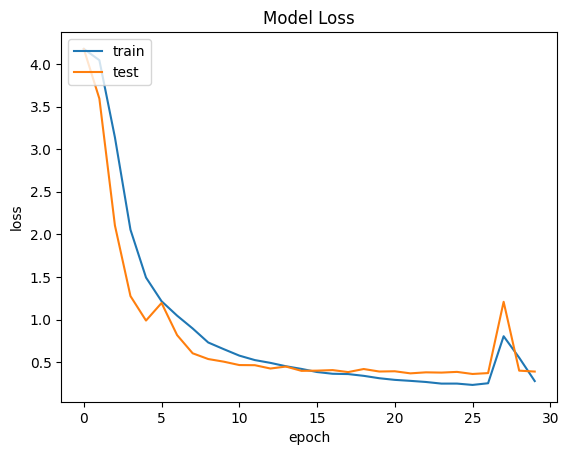

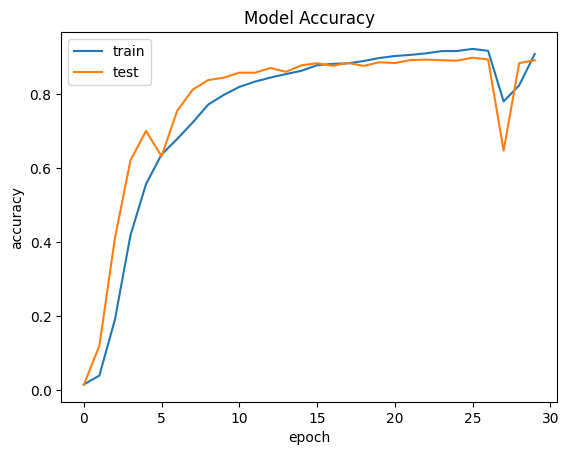

Found 10640 files belonging to 1 classes.
21/21 [==============================] - 5s 233ms/step


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

datasets = ['/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train',\
            '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test',
           '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset']
NUM_CLASS = 65
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 512
SEED = 42
EPOCHS = 30

train_images = tf.keras.utils.image_dataset_from_directory(
    datasets[0],
    validation_split=0.2,
    color_mode='grayscale',
    label_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

train_validation = tf.keras.utils.image_dataset_from_directory(
    datasets[0],
    validation_split=0.2,
    label_mode="categorical",
    color_mode='grayscale',
    subset="validation",
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASS, activation=tf.nn.softmax)
])
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model.summary()

learning_rate = 0.001
lr_mod = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=100000,\
                                                             decay_rate=0.96, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_mod), loss='categorical_crossentropy', metrics=['accuracy'])

h1 = model.fit(train_images,
               validation_data=train_validation,
               epochs=EPOCHS)

plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(h1.history['accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the model
model.save('/kaggle/working/test_2.keras')

# Load the model
model = tf.keras.models.load_model('/kaggle/working/test_2.keras')

test_images = tf.keras.utils.image_dataset_from_directory(
    datasets[1],
    labels=None,
    label_mode="categorical",
    color_mode='grayscale',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

predictions = model.predict(test_images)
img_list = os.listdir(datasets[1])
labels_list = sorted(os.listdir(datasets[0]))

df_predictions = pd.DataFrame(columns=['ID', 'Label'], dtype=(np.int32, np.int32))

predictions_mod = np.argmax(predictions, 1)

for idx, image in enumerate(sorted(img_list)):
    df2 = pd.DataFrame([[int(image.split(".")[0]), int(labels_list[predictions_mod[idx]])]], columns=['ID', 'Label'])
    df_predictions = pd.concat([df_predictions, df2])

df_predictions.sort_values(by='ID', inplace=True)
df_predictions.reset_index(drop=True)

# Save the results to a CSV file
df_predictions.to_csv('/kaggle/working/arabicproject.csv', index=False, header=True)